In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import growth_curve_analysis as od

In [3]:
# Specify plot formatting options
sns.set_context('paper', font_scale=1.3)
sns.set_style('whitegrid')
sns.set_palette(['#0365C0','#E31B1C','#70BF41','#F39019','#773F9B','#85888D']) # custom color palette
sns.set_style({'axes.edgecolor': 'black', 'grid.color': 'black'})
plt.rc('text', usetex=False)

When I import the raw data, I will need to do some transformations that are also done in growth_curve_analysis.py, such as formatting the time and correcting for the non-linearity of high OD readings. Here I am initializing these functions in the notebook.

In [4]:
correction = [0.6, 0.2141, 1.7935]

def transform(x):
    if x > correction[0]:
        y = np.around(correction[1]*np.exp(correction[2]*x), 3)
    else: y = x
    return y

def reformat_time(x):
    if type(x) not in ['int64', 'float64']:  # if numeric, assume minutes
        elapsed_time = od.reformat_time(str(x))
    else: elapsed_time = x
    time_in_hours = elapsed_time/60
    return time_in_hours

All of my raw data files are named according to date, so here I am listing the dates of the experiment data I want to work with.

In [5]:
dates = ['20160719', '20160720', '20160721']

I will read in the raw data along with the plate layout information for each experiment.

In [6]:
data_dict = {}
layout_dict = {}
blank_file = pd.read_excel('/Users/nwespe/Desktop/Pop-GROC/gen_blank_file.xlsx')
for d in dates:
    data = pd.read_csv('/Users/nwespe/Desktop/Pop-GROC/'+d+'/'+d+' ypd nacl data.txt', 
                       sep='\t', converters ={'strain': lambda x: str(x), 
                                              'name': lambda x: str(x)})
    no_time = data.iloc[:, 1:]
    blanked_data = pd.DataFrame(no_time.values-blank_file.values, columns=no_time.columns)
    adj_data = blanked_data.applymap(transform)
    adj_data['Kinetic read'] = data['Kinetic read']
    data_dict[d] = adj_data
    layout_dict[d] = pd.read_excel('/Users/nwespe/Desktop/Pop-GROC/'+d+'/'+d+' ypd nacl layout.xlsx', 
                                   converters ={'strain': lambda x: str(x), 'name': lambda x: str(x)})

Now I will create a dataframe of all of the data. In order to plot data from multiple wells and experiments together, I need to normalize properly. I will do this by dividing each OD value by the initial OD. I will also create a dataframe of the log-transformed normalized data and add the metadata from the plate layout files.

In [7]:
norm_data_dict = {}
log_norm_data_dict = {}
for d in dates:
    orig_data = data_dict[d]
    orig_data['time'] = orig_data['Kinetic read'].apply(lambda x: reformat_time(x))
    times = orig_data['time']
    only_ODs = orig_data.drop(['Kinetic read', 'time'], axis=1)
    norm_data = only_ODs/only_ODs.iloc[0]
    norm_data['time'] = times
    norm_data_dict[d] = norm_data
    log_norm_data = np.log(norm_data)
    log_norm_data['time'] = times
    log_norm_data_dict[d] = log_norm_data
    
all_norm_data = []
for d in dates:
    orig_data = norm_data_dict[d]
    flipped_data = orig_data.T
    flipped_data.columns = flipped_data.loc['time']
    flipped_data.drop('time', inplace=True)
    layout = layout_dict[d]
    keyed_data = pd.merge(flipped_data, layout, right_on='well', left_index=True)
    all_norm_data.append(keyed_data)
    
all_log_norm_data = []
for d in dates:
    orig_data = log_norm_data_dict[d]
    flipped_data = orig_data.T
    flipped_data.columns = flipped_data.loc['time']
    flipped_data.drop('time', inplace=True)
    layout = layout_dict[d]
    keyed_data = pd.merge(flipped_data, layout, right_on='well', left_index=True)
    all_log_norm_data.append(keyed_data)
    
norm_data_df = pd.concat(all_norm_data)
trimmed_norm_data = norm_data_df.drop(['run', 'strain', 'clone', 'replicate'], axis=1)

log_norm_data_df = pd.concat(all_log_norm_data)
trimmed_log_norm_data = log_norm_data_df.drop(['run', 'strain', 'clone', 'replicate'], axis=1)

In order to use the seaborn tsplot function for the data, the dataframe has to be arranged in a very specific way. This function creates a 'long-form' dataframe of the subset of data to be plotted.

In [8]:
def get_long_form(data, val):
    lf_data = pd.melt(data, id_vars = ['name', 'media', 'expt_date', 'well'], var_name='time', value_name=val)
    lf_data['expt_date'] = lf_data['expt_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
    lf_data['sample'] = lf_data['expt_date'] + ' ' + lf_data['well']
    return lf_data

I will first show example plots of data for a single strain. Here I will separate the data based on media type. The data are plotted with a light line for each replicate and a dark line representing the mean value of the replicates at each timepoint with interpolation between the timepoints. See seaborn.tsplot for more details.

In [9]:
strain = '006A'

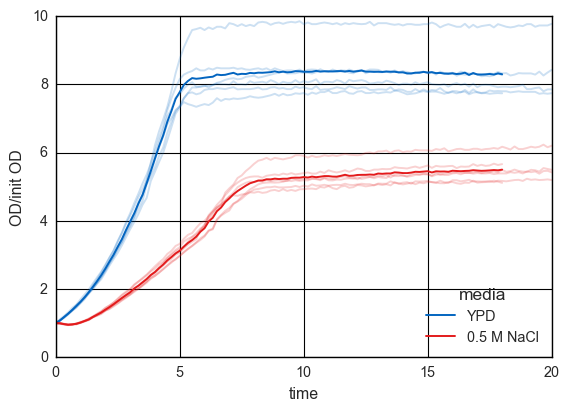

In [10]:
subset = trimmed_norm_data[trimmed_norm_data.name == strain]
lf_norm_data = get_long_form(subset, 'OD/init OD')

fig = plt.figure()
ax = sns.tsplot(data=lf_norm_data, time='time', value='OD/init OD', unit='sample', condition='media', 
                err_style='unit_traces')
fig.savefig('/Users/nwespe/Desktop/Agg-plots/'+strain+'_norm_growth.svg', format='svg', bbox_inches='tight')

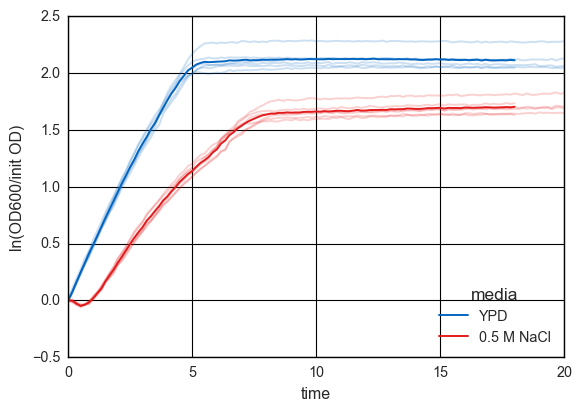

In [22]:
subset = trimmed_log_norm_data[trimmed_log_norm_data.name == strain]
subset.reset_index(inplace=True, drop=True)
lf_log_norm_data = get_long_form(subset, 'ln(OD600/init OD)')

fig = plt.figure()
ax = sns.tsplot(data=lf_log_norm_data, time='time', value='ln(OD600/init OD)', unit='sample', condition='media', 
                err_style='unit_traces')
fig.savefig('/Users/nwespe/Desktop/Agg-plots/'+strain+'_log_norm_growth.svg', format='svg', bbox_inches='tight')

Now I want to plot multiple strains per plot. I will choose my strains from the strains available in the datasets loaded.

In [12]:
pd.unique(trimmed_log_norm_data.name)

array(['003', '006A', '115', '209', '116', '210', '190', '226', '191',
       '219', '207', '208', '034A', '215', '111c3', '255', '178', '169',
       'blank', '114', '216', '202', '170'], dtype=object)

In [13]:
strain_list = ['006A', '114', '115', '116']
group = 'non-mutator evolved'

Here I will specify which type of data I want plotted. I can also specify a timeframe instead of plotting the entire timecourse. I just need to make sure that the last assignment to the variable 'data' is the subset of data to be plotted.

In [14]:
data = trimmed_log_norm_data  # or trimmed_norm_data
val = 'ln(OD/init OD)'  # or 'OD/init OD'

In [15]:
# to plot a time subset of the data
first_three_hrs = pd.concat([data.iloc[:, 0:19], data.iloc[:, -4:]], axis=1)
first_six_hrs = pd.concat([data.iloc[:, 0:37], data.iloc[:, -4:]], axis=1)
first_twelve_hrs = pd.concat([data.iloc[:, 0:73], data.iloc[:, -4:]], axis=1)
data = first_six_hrs

First I will separate the data for each media type into two plots. 

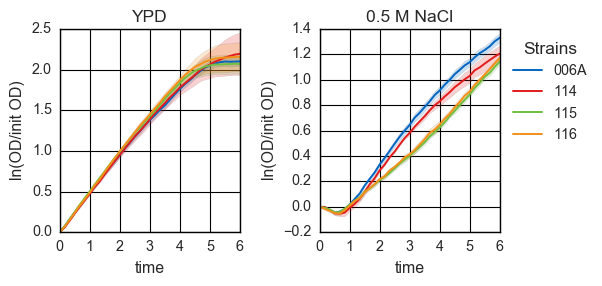

In [16]:
# for multiple strains on one plot, with media split into 2 plots

palette = sns.color_palette()  # make sure palette has enough colors
fig = plt.figure(figsize=(5.3,3))
media = ['YPD', '0.5 M NaCl']
media1_data = data[data.media == media[0]]
media2_data = data[data.media == media[1]]

med1 = fig.add_subplot(121, adjustable='box')
x = 0
for s in strain_list:
    subset = media1_data[media1_data.name == s]
    lf_data = get_long_form(subset, val)
    ax1 = sns.tsplot(data=lf_data, time='time', value=val, unit='sample', condition='media', 
                     color = palette[x], legend=False, ci=95)
    x += 1
plt.title(media[0])

med2 = fig.add_subplot(122, adjustable='box')
x = 0
for s in strain_list:
    subset = media2_data[media2_data.name == s]
    lf_data = get_long_form(subset, val)
    ax2 = sns.tsplot(data=lf_data, time='time', value=val, unit='sample', condition='media', 
                     color = palette[x], ci=95) 
    x += 1
plt.title(media[1])

med2.legend(strain_list, title = 'Strains', bbox_to_anchor=(1,1), loc=2)
plt.tight_layout()
fig.savefig('/Users/nwespe/Desktop/Agg-plots/'+group+'_log_norm_growth.svg', format='svg', 
            bbox_inches='tight')

I can also plot all of the above samples on the same plot. Since I am specifying the color for each timeseries, I need to make sure that the color palette contains enough colors.

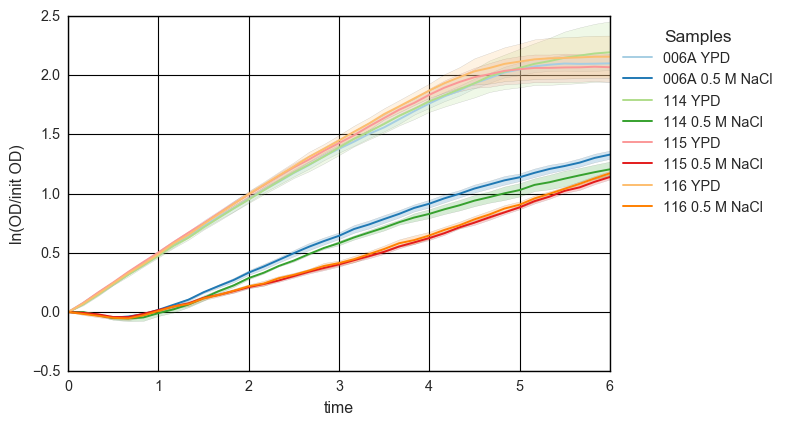

In [21]:
# for multiple strains and media types on one plot
palette = sns.color_palette('Paired', 4*len(strain_list))  # make sure palette has enough colors

fig = plt.figure()
x, y = 0, 1
media = ['YPD', '0.5 M NaCl']
for s in strain_list:
    color_dict = {media[0]: palette[x], media[1]: palette[y]}
    subset = data[data.name == s]
    lf_data = get_long_form(subset, val)
    ax = sns.tsplot(data=lf_data, time='time', value=val, unit='sample', 
                    condition='media', color = color_dict, ci=95)
    x += 2; y += 2

legend_labels = []
for s in strain_list: 
    legend_labels.extend([s +' '+ media[0], s +' '+ media[1]])
ax.legend(legend_labels, title = 'Samples', bbox_to_anchor=(1,1), loc=2)

plt.tight_layout()
fig.savefig('/Users/nwespe/Desktop/Agg-plots/'+group+'_log_norm_oneplot.svg', format='svg', 
            bbox_inches='tight')